## Credit card approval Model

In [22]:
# import packages

import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report


warnings.filterwarnings("ignore")

In [2]:
# read the data
DATA = pd.read_csv('cleaned_data.csv')
DATA = DATA.drop('Unnamed: 0', axis=1)
DATA.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,Class
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [3]:
#convert categorical columns to numeric columns by label encoding them
CAT_COL = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']
LE = LabelEncoder()
for col in CAT_COL:
    DATA[col] = LE.fit_transform(DATA[col])

In [4]:
#target column for the model
Y = DATA['Class']

In [5]:
#drop the DriversLicense and ZipCode columns

COL_TO_DROP = ['A12', 'A14', 'Class']
DATA = DATA.drop(COL_TO_DROP, axis=1)

In [6]:
#convert the data to numpy array
Y_NUMPY = Y.to_numpy()
NUMPY_DATA = DATA.to_numpy()

In [7]:
#split data into train and test
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(NUMPY_DATA, Y_NUMPY, test_size=0.2)

In [8]:
#scale the dataset
SCALED = StandardScaler()
X_TRAIN_SCALED = SCALED.fit_transform(X_TRAIN)
X_TEST_SCALED = SCALED.transform(X_TEST)

In [9]:
#build baseline model
LOGREG = LogisticRegression()
LOGREG.fit(X_TRAIN_SCALED, Y_TRAIN)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
#make predictions
PRED = LOGREG.predict(X_TEST_SCALED)

In [11]:
#Print the train and test accuracy for the baseline model
print('Train Accuracy is: ' + str(LOGREG.score(X_TRAIN_SCALED, Y_TRAIN)))
print('Test accuracy is: '+ str(LOGREG.score(X_TEST_SCALED, Y_TEST)))

Train Accuracy is: 0.855072463768116
Test accuracy is: 0.9130434782608695


In [12]:
#classification report
print(classification_report(Y_TEST, PRED))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        79
           1       0.83      1.00      0.91        59

    accuracy                           0.91       138
   macro avg       0.92      0.92      0.91       138
weighted avg       0.93      0.91      0.91       138



In [13]:
PREDICTIONS_PROBA = LOGREG.predict_proba(X_TEST_SCALED)[:, 1]
FPR, TPR, THRESHOLDS = roc_curve(Y_TEST, PREDICTIONS_PROBA)
AUC_SCORE = auc(FPR, TPR)
print('The auc score for the model is: {}'.format(AUC_SCORE))

The auc score for the model is: 0.9697489809053852


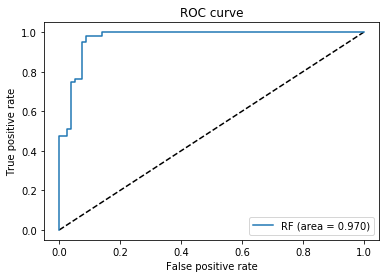

In [14]:
#plot the ROC curve for the model

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(FPR, TPR, label='RF (area = {:.3f})'.format(AUC_SCORE))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [15]:
#Tune the model using grid search and choosing the best parameter

PARAM_GRID = {
        'penalty' : ['l1', 'l2'],
        'C' : [0.001, .009, 0.01, .09, 1, 5, 10, 25]}
LOGREG_CV = GridSearchCV(LOGREG, PARAM_GRID, cv=5, scoring='roc_auc')
LOGREG_CV.fit(X_TRAIN_SCALED, Y_TRAIN)


/home/godwin/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [16]:
#best parameters and model accuracy
print("best parameters ", LOGREG_CV.best_params_)
print("accuracy :", LOGREG_CV.best_score_)

best parameters  {'C': 1, 'penalty': 'l1'}
accuracy : 0.9038570571968394


In [17]:
#fit the model with the best parameters gotten from the parameter tuning
BEST_LOGREG = LogisticRegression(C=LOGREG_CV.best_params_['C'], 
                                 penalty=LOGREG_CV.best_params_['penalty'])
BEST_LOGREG.fit(X_TRAIN_SCALED, Y_TRAIN)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
print('Train Accuracy is: ' + str(BEST_LOGREG.score(X_TRAIN_SCALED, Y_TRAIN)))
print('Test Accuracy is: ' + str(BEST_LOGREG.score(X_TEST_SCALED, Y_TEST)))

Train Accuracy is: 0.8514492753623188
Test Accuracy is: 0.9130434782608695


In [19]:
#Print the classification report for the new model
PREDICTIONS = BEST_LOGREG.predict(X_TEST_SCALED)
print(classification_report(Y_TEST, PREDICTIONS))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        79
           1       0.83      1.00      0.91        59

    accuracy                           0.91       138
   macro avg       0.92      0.92      0.91       138
weighted avg       0.93      0.91      0.91       138



In [20]:
#get the prediction probability and use it to get the auc_score
NEW_PREDICTIONS_PROBA = BEST_LOGREG.predict_proba(X_TEST_SCALED)[:, 1]
FPR, TPR, THRESHOLDS = roc_curve(Y_TEST, NEW_PREDICTIONS_PROBA)
NEW_AUC_SCORE = auc(FPR, TPR)
print('The auc score for the model is: {}'.format(NEW_AUC_SCORE))

The auc score for the model is: 0.9703926196095258


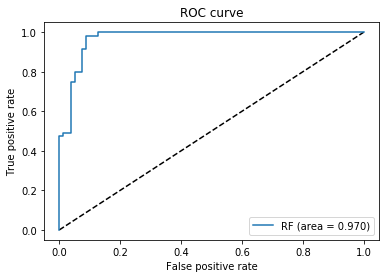

In [21]:
#Plot the ROC curve for the improved model
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(FPR, TPR, label='RF (area = {:.3f})'.format(NEW_AUC_SCORE))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()